###  IBM Data Science Final Project

# Forming a Recommender System on the Basis of K-Means Similarity Metrics

_Louis X. Meikle_

## Introduction

I live in London and if there's one thing I've realised by living here a good two decades is that London is diverse, varied and vibrant in it's culture; a true synthesis of identies and ideas. So, accordingly, I've wondered about how to apply my data science skillset to my city. Then, I thought "How can I make sense of this madness and how can I help people with my conclusions?". I then considered that could create a system that allows people to put in a place they already like and get a reccomendation out!
Hopefully, by using this, I should be able to give people fair reccomendations so that they have a good time out in London!

## Business Problem

Let us say that a ficticous business (which I will hence refer to as Mercury Travel Ltd) wants to create a recommender system that allows for it's clients to be recommeded a location in London to go to based on previous places they liked. This is done because their previous method (which involved taking local and possibly biased tips) was ineffecitive and often led clients to unpleasant locations. The goal here it to create a recommendation system that can accurately and reliably give a recommendation to someone given their prior locations.

I will be using K-Means clustering for my segmentation of different groups in London as it produces clusters with high similarity and it is also a fairly reliable approach so it is fairly decent for a recommender system. I am also using an item-based approach to constructing my recommender system not only because I can't gain data about individual preferences at the moment but also because locations change less frequently than user preferences so the system will generally be more stable.

(For a summary for the differences in recommender systems see below:)

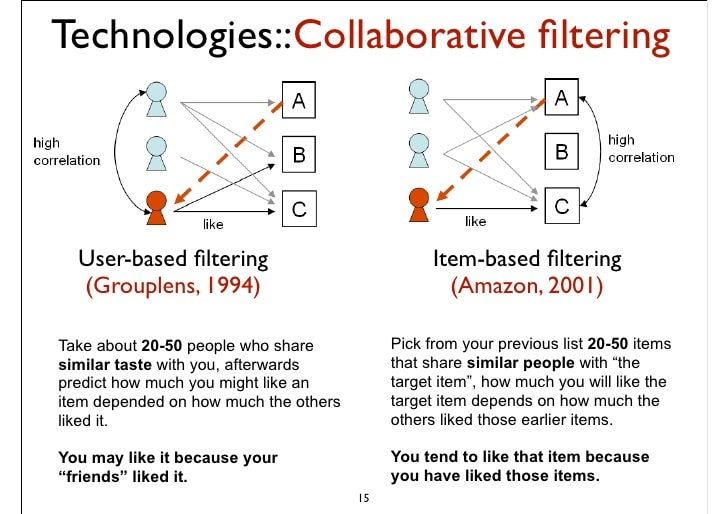

## Data

My data will be retrieved from the Foursquare API as it has a comprehensive list of many different types of locations in London as well as tangential data such as tips and reviews that could help me to clean my data set. Foursquare can have some slight problems in reliability given that data is still crowdsourced so we will have to implement some cleaning methods for the data to make sure that it allows for a well functioning model. After all, if we have a poor input we're going to get a poor output.

_Library Import:_

In [1]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.colors as colors
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import re
import json
import requests
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from geopy.geocoders import Nominatim
!pip install folium==0.5.0
import folium

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210718191456-0000
KERNEL_ID = 8b4fbe7b-3e81-4478-9d2c-3eb838085949
     |████████████████████████████████| 79 kB 2.6 MB/s  eta 0:00:01
     |████████████████████████████████| 133 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 638 kB/s  eta 0:00:01
     |████████████████████████████████| 138 kB 41.3 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 145 kB 46.8 MB/s eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=6a282fb99fe8693e898c43e1ae414cae04089bd629e6978348632cb64ea89554
  Stored in directory: /home/spark/shared/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
ERROR: conda 4.8.2 requires ruamel_yaml>=0.11.14, which is not installed.
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_ve

Firstly, let's put in our details for accessing the Foursquare API. I'm also going to say to set the values near 'London, UK'. This generally puts us on what many maps consider to be the centre of London; Charing Cross Station.

In [2]:
CLIENT_ID = '5SURA10V3SIWTW3NPURH4XKLJ5MXWXDY5FO20FYS5E5TDB3J'
CLIENT_SECRET = '5RCCCZNL4XODLRU3TPA4ASYQNDZX0LNJW5MTJN4QAUTQRKJN'
ACCESS_TOKEN = 'GBOEXXHQHXPVH0X21JPVFDMMUMWTASX4VQOVXJQLGW1JPKKW'
VERSION = '20180604'
LIMIT= 100000
radius = 100000
near = 'London, UK'

Let's now define the URL we're going to be extract our data from...

In [3]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near)
url

'https://api.foursquare.com/v2/venues/search?client_id=5SURA10V3SIWTW3NPURH4XKLJ5MXWXDY5FO20FYS5E5TDB3J&client_secret=5RCCCZNL4XODLRU3TPA4ASYQNDZX0LNJW5MTJN4QAUTQRKJN&oauth_token=GBOEXXHQHXPVH0X21JPVFDMMUMWTASX4VQOVXJQLGW1JPKKW&v=20180604&radius=100000&limit=100000&near=London, UK'

...and then let's see our data!

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60f49e4d7bb31a3b256e7a54'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '52024d08498eb0286116073e',
    'name': 'Charing Cross Station Bus Stop H',
    'location': {'address': 'The Strand',
     'crossStreet': 'Villliers St',
     'lat': 51.508143,
     'lng': -0.12476,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.508143,
       'lng': -0.12476}],
     'postalCode': 'WC2N 5HF',
     'cc': 'GB',
     'neighborhood': 'Charing Cross',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['The Strand (Villliers St)',
      'London',
      'Greater London',
      'WC2N 5HF']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b4f',
      'name': 'Bus Stop',
      'pluralName': 'Bus Stops',
      'shortName': 'Bus Stop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/busstation_',
       'su

Alright then! This seems OK for now. We've got our venues plus information about location, address, business type and a whole lot more. Now let's see it in a nice looking table!

In [22]:
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
dataframe.head(100000)

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location_formattedAddress,venuePage.id
0,52024d08498eb0286116073e,Charing Cross Station Bus Stop H,"[{'id': '52f2ab2ebcbc57f1066b8b4f', 'name': 'B...",v-1626644045,False,The Strand,Villliers St,51.508143,-0.124760,"[{'label': 'display', 'lat': 51.508143, 'lng':...",WC2N 5HF,GB,Charing Cross,London,Greater London,United Kingdom,"[The Strand (Villliers St), London, Greater Lo...",NaN
1,4ac518f6f964a52050af20e3,Charing Cross Railway Station (CHX),"[{'id': '4bf58dd8d48988d129951735', 'name': 'T...",v-1626644045,False,Strand,NaN,51.507953,-0.124328,NaN,WC2N 5HF,GB,NaN,London,Greater London,United Kingdom,"[Strand, London, Greater London, WC2N 5HF]",NaN
2,4d667b231658721e1336c804,Co-op Food,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1626644045,False,456-459 Strand,NaN,51.508361,-0.126358,"[{'label': 'display', 'lat': 51.50836074213148...",WC2R 0RG,GB,NaN,London,Greater London,United Kingdom,"[456-459 Strand, London, Greater London, WC2R ...",NaN
3,4bfd71712b83b713bbb7a998,Charing Cross London Underground Station,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1626644045,False,Trafalgar Sq,at Strand,51.507685,-0.128210,"[{'label': 'display', 'lat': 51.50768525914683...",WC2N 5DR,GB,NaN,London,Greater London,United Kingdom,"[Trafalgar Sq (at Strand), London, Greater Lon...",NaN
4,4cb1d0e2562d224bfdb42188,"""A Conversation With Oscar Wilde"" statue","[{'id': '507c8c4091d498d9fc8c67a9', 'name': 'P...",v-1626644045,False,Adelaide St.,Btw King William IV & Duncannon,51.508702,-0.125991,"[{'label': 'display', 'lat': 51.50870249627353...",WC2 N 5,GB,NaN,London,Greater London,United Kingdom,[Adelaide St. (Btw King William IV & Duncannon...,NaN
5,4bcc979fb6c49c7417029491,Jigsaw,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",v-1626644045,False,450 Strand,NaN,51.508393,-0.125725,"[{'label': 'display', 'lat': 51.50839295345701...",WC2R 0RG,GB,NaN,London,Greater London,United Kingdom,"[450 Strand, London, Greater London, WC2R 0RG]",NaN
6,4b5061def964a520cb2127e3,Pizza Express,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1626644045,False,450 Strand,NaN,51.508464,-0.126157,"[{'label': 'display', 'lat': 51.50846400384665...",WC2R 0RG,GB,NaN,London,Greater London,United Kingdom,"[450 Strand, London, Greater London, WC2R 0RG]",NaN
7,518aa1f9498e8c5e745fd352,The Connection of St Martins in the Field,"[{'id': '50328a8e91d4c4b30a586d6c', 'name': 'N...",v-1626644045,False,12 Adelaide St,NaN,51.508766,-0.126006,"[{'label': 'display', 'lat': 51.508766, 'lng':...",WC2N 4HW,GB,NaN,London,Greater London,United Kingdom,"[12 Adelaide St, London, Greater London, WC2N ...",NaN
8,4c383b962c8020a1827f8a00,Paul,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",v-1626644045,False,11 Strand,outside Charing Cross Station,51.508431,-0.125708,"[{'label': 'display', 'lat': 51.50843075823572...",WC2N 5HR,GB,NaN,London,Greater London,United Kingdom,"[11 Strand (outside Charing Cross Station), Lo...",NaN
9,5d964497d4d3630007901c48,Tfl Bus 6,"[{'id': '4bf58dd8d48988d12b951735', 'name': 'B...",v-1626644045,False,NaN,NaN,51.508465,-0.138567,"[{'label': 'display', 'lat': 51.508465, 'lng':...",W1A 1ER,GB,NaN,NaN,NaN,United Kingdom,[W1A 1ER],NaN


Ok then. We seem to have retrieved the location data for 128 venues. This is good, but we're going to need more. After all, we can't cover all of London with just 128 venues nor can we train a model with that either! For now though, this proves that my data is showing up and that it can work for my intended purpose which is the most important thing here.

Let's have a look at the names of institutions here:

In [23]:
dataframe.name

0                       Charing Cross Station Bus Stop H
1                    Charing Cross Railway Station (CHX)
2                                             Co-op Food
3               Charing Cross London Underground Station
4               "A Conversation With Oscar Wilde" statue
5                                                 Jigsaw
6                                          Pizza Express
7              The Connection of St Martins in the Field
8                                                   Paul
9                                              Tfl Bus 6
10                                The Strand Sausage Co.
11                                            Platform 1
12                                Vauxhall End, The Oval
13                                                Crussh
14                                     Minamoto Kitchoan
15                                               WHSmith
16                       Adelaide Ice Cream And Hot Dogs
17                             

We've got some bad data entries here. For example, take number 1 and 2 here. I highly doubt that people would like to visit a bus stop whilst they're in London (unless they're public transport enthusiasts?). We're going to have to remove these sorts of invalid venues before they become a problem in later data analysis. I'll leave that to future me to take on next week!

Finally, I'm curious to see what our data looks like on a map. Let's take a peek!
(P.S; Latitude and Longitude here are set to Charing Cross Station.)

In [24]:
latitude = 51.507953
longitude = -0.124328

venues_map = folium.Map(location=[latitude, longitude], zoom_start=18)
for lat, lng, label in zip(dataframe.location_lat, dataframe.location_lng, dataframe.location_formattedAddress):
    folium.CircleMarker(
        [lat, lng],
        radius=3.5,
        color='black',
        popup= folium.Popup(label),
        fill = True,
        fill_color='gray',
        fill_opacity=0.8
    ).add_to(venues_map)

venues_map